# Disaster Tweet Prediction


>                 For a beginner,Starting out in NLP is quite a challenge,atleast for me it was. This is such an emerging field that the developments are happening at a very rapid rate. So coping up in NLP would feel a bit difficult. I had to go through many resources and notebooks on Kaggle and GitHub in order to get a better understanding of the concepts and I did not have a clear roadmap as to how to proceed.This book is created in such a way that anyone starting out in the NLP would atleast get an idea of how to start and proceed. I have tried to touch upon the topics I felt should be known and the link to the resources for the topics are provided in the respective sections.

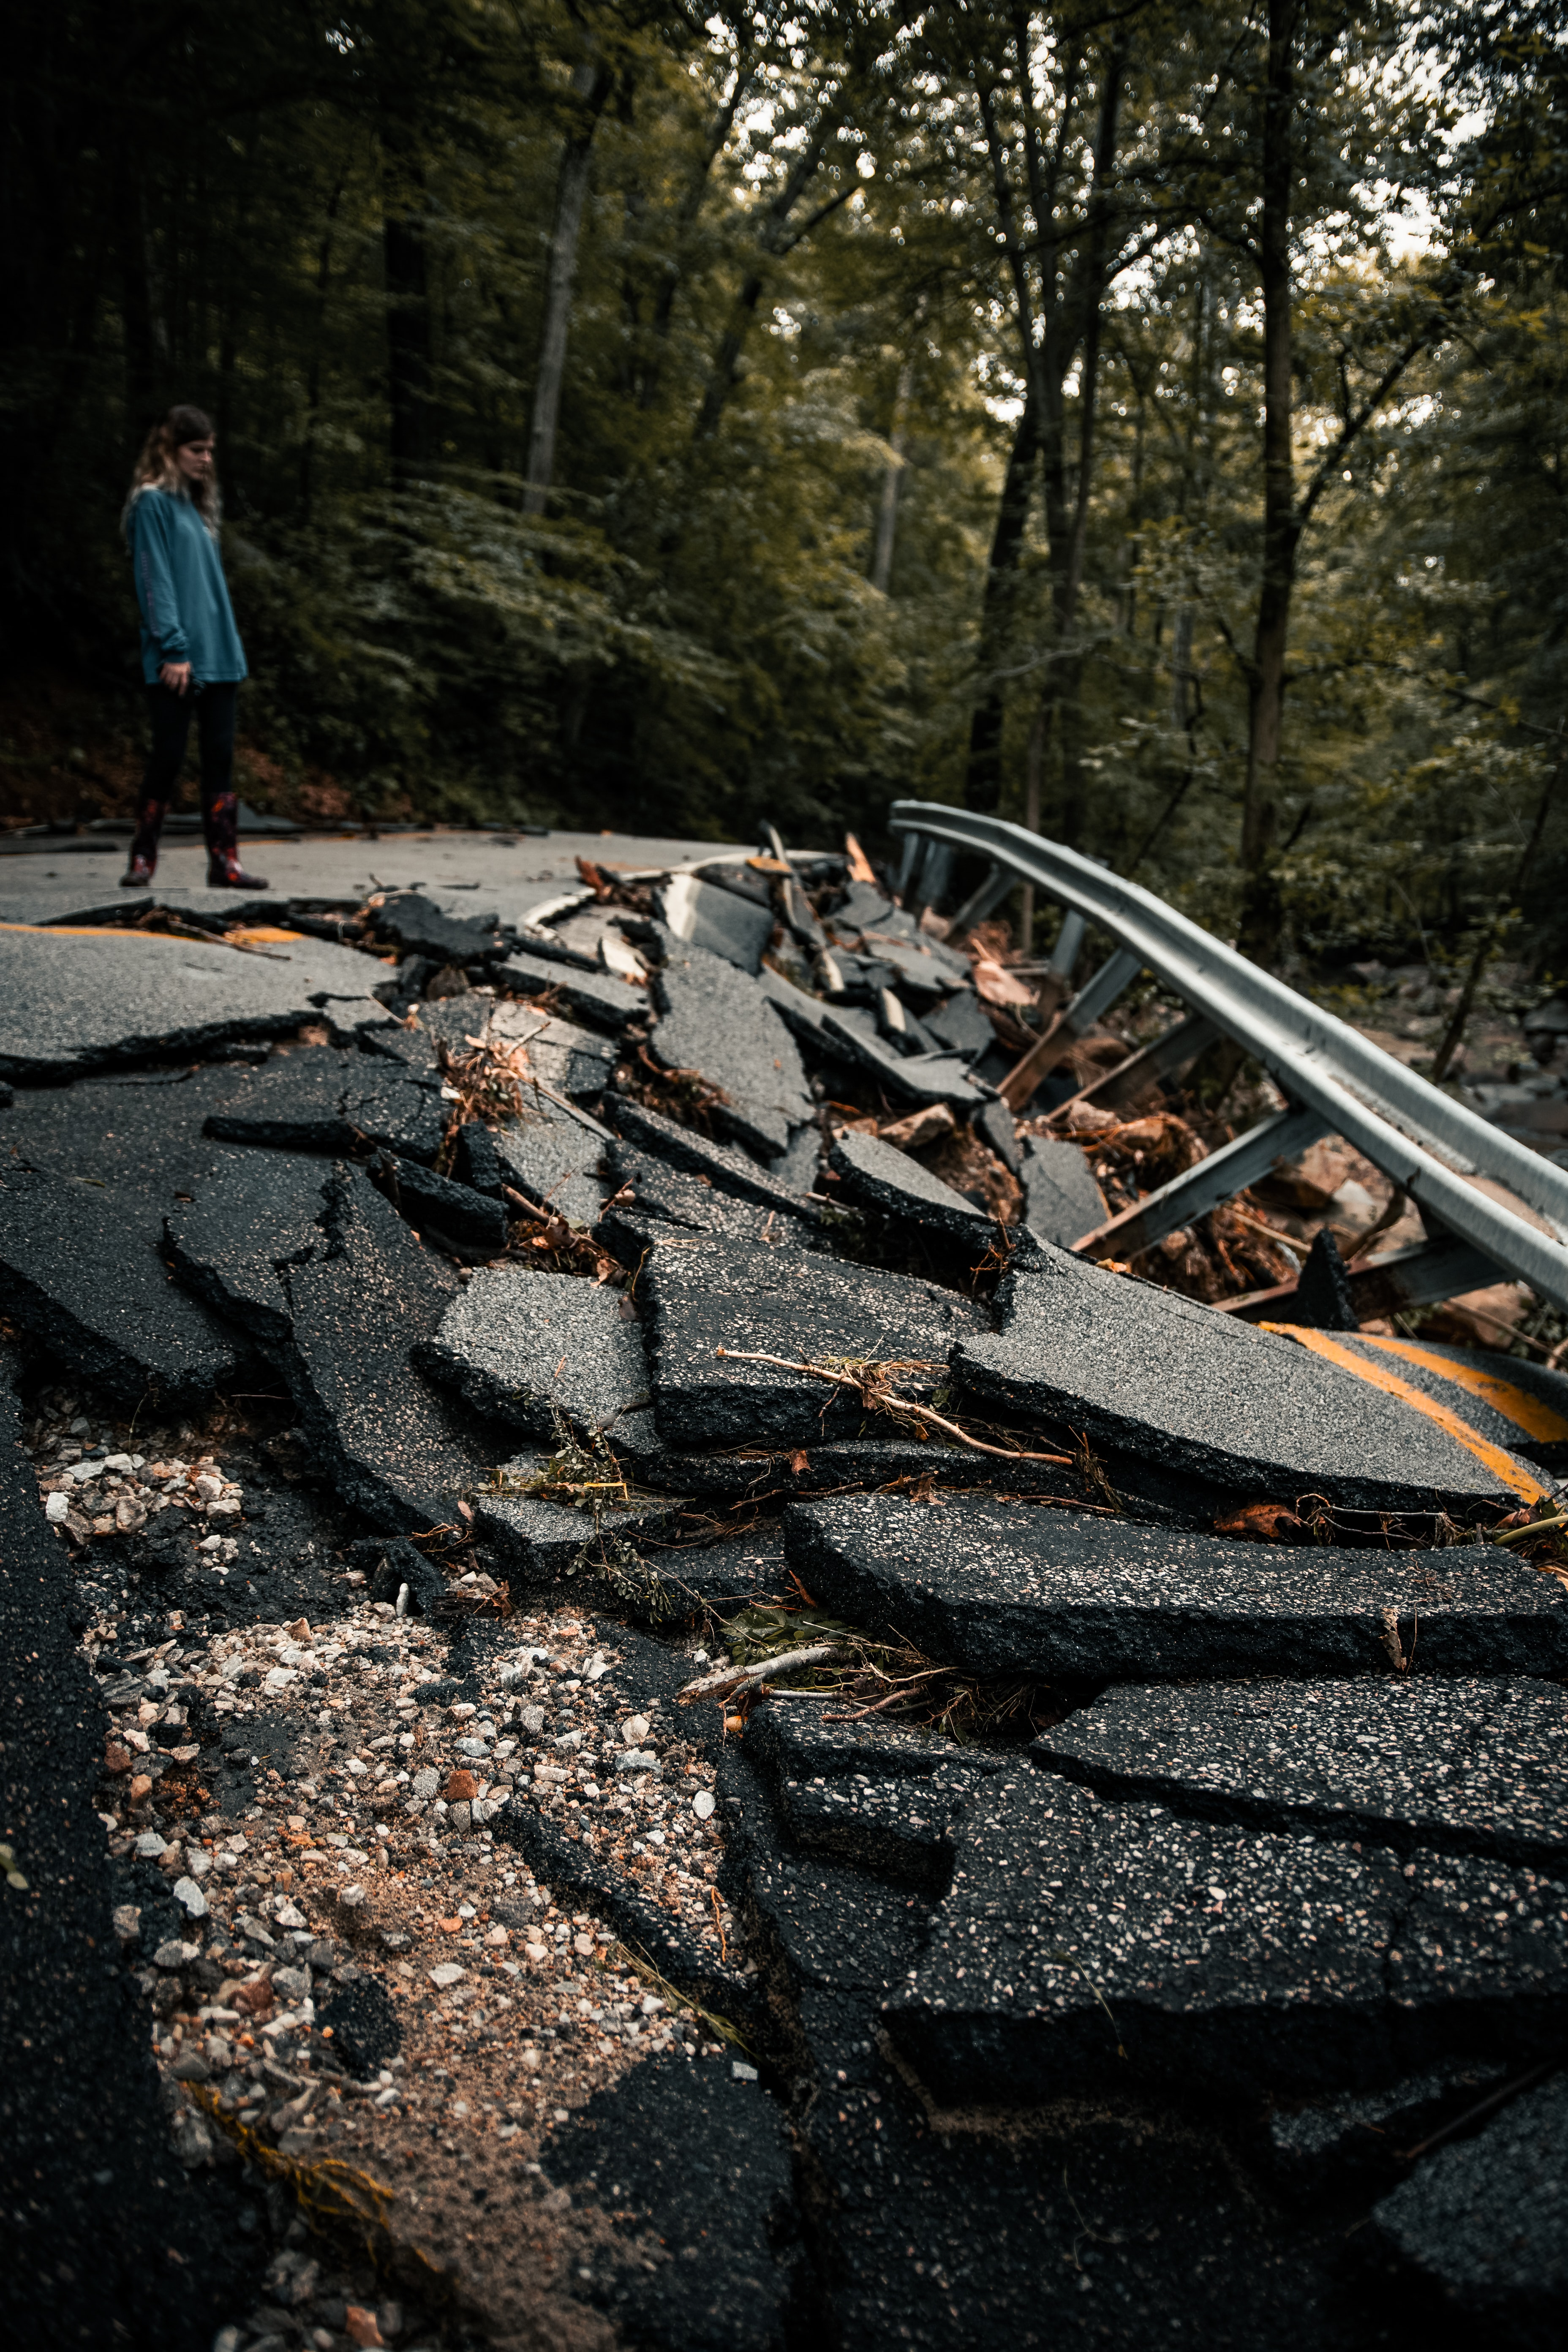

# Importing the Libraries and the dataset

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py


In [ ]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize,word_tokenize

In [ ]:
df_train=pd.read_csv('../input/nlp-getting-started/train.csv')
df_test=pd.read_csv('../input/nlp-getting-started/test.csv')

In [ ]:
df_train.head()

In [ ]:
df_train.shape

# EDA

##### missingno is a library that is used to visualize the missing values. The missing values can be visualized using barplot,matrix plot or heatmap. For reference you can visit this github page:
[https://github.com/ResidentMario/missingno](https://github.com/ResidentMario/missingno)

In [ ]:
missingno.bar(df_train,sort="ascending", figsize=(10,5), fontsize=12)

In [ ]:
sns.countplot(df_train['target'])

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=df_train['location'].value_counts()[:20],y=df_train['location'].value_counts()[:20].index)


In [ ]:
len(df_train)

In [ ]:
df_train[df_train['target']==0]['location'].value_counts()[:20]


In [ ]:
df_train[df_train['target']==0]['location'].value_counts()[:20].index


## Top Location based on Tweets(Disaster or Non-Disaster)


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Location',size=30)



sns.barplot(ax=axes[0],x=df_train[df_train['target']==0]['location'].value_counts()[:15],y=df_train[df_train['target']==0]['location'].value_counts()[:15].index)
axes[0].set_title('Non-Disaster',size=25)
y0=df_train[df_train['target']==0]['location'].value_counts()[:15].index
axes[0].set_yticklabels(y0, fontsize=20)

sns.barplot(ax=axes[1],x=df_train[df_train['target']==1]['location'].value_counts()[:15],y=df_train[df_train['target']==1]['location'].value_counts()[:15].index)
axes[1].set_title('Disaster',size=25)
y1=df_train[df_train['target']==1]['location'].value_counts()[:15].index
axes[1].set_yticklabels(y1, fontsize=20)


In [ ]:
df_train[df_train['location']=='India'][['text','target']]

In [ ]:
list(set(df_train['keyword']))==list(set(df_test['keyword']))

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=df_train['keyword'].value_counts()[:15],y=df_train['keyword'].value_counts()[:15].index)

In [ ]:
df_train[df_train['target']==0]['keyword'].value_counts()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Keywords',size=30)

sns.barplot(ax=axes[0],x=df_train[df_train['target']==1]['keyword'].value_counts()[:30],y=df_train[df_train['target']==1]['keyword'].value_counts()[:30].index)
axes[0].set_title('Disaster',size=25)
y0=df_train[df_train['target']==1]['keyword'].value_counts()[:30].index
axes[0].set_yticklabels(y0, fontsize=20)

sns.barplot(ax=axes[1],x=df_train[df_train['target']==0]['keyword'].value_counts()[:30],y=df_train[df_train['target']==0]['keyword'].value_counts()[:30].index)
axes[1].set_title('NonDisaster',size=25)
y1=df_train[df_train['target']==0]['keyword'].value_counts()[:30].index
axes[1].set_yticklabels(y1, fontsize=20)


In [ ]:
df_train.loc[2,'text']

In [ ]:
word_length=[]
for i in df_train['text']:
    word_length.append(len(i.split()))
    
plt.figure(figsize=(12,8))
sns.kdeplot(word_length,hue=df_train['target'],fill=True)

In [ ]:
lemma=WordNetLemmatizer()
cv=CountVectorizer(ngram_range=(1,2),max_features=10000)

# Porter Stemmer or Snowball Stemmer can also be used instead of Wordnet lemmatizer and tfidf or hashing vectorizer can also be used in place of count vectorizer

In [ ]:

def most_freqent_words(data=df_train,target=1,n=15,n_grams=1):
    corpus=[]
    
    for i in df_train[df_train['target']==target]['text']:
        review=re.sub(r'https?://\S+|www\.\S+','',i)
        review=re.sub(r'<.*?>','',review)
        review=re.sub('[^a-zA-Z]',' ',review)
        review=review.lower()
        review=review.split()
        review=[lemma.lemmatize(word) for word in review if not word in stopwords.words('english')]
        review=' '.join(review)
        corpus.append(review)
        
    vec = CountVectorizer(ngram_range=(n_grams, n_grams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    top_words=[]
    top_freq=[]
    for word, freq in words_freq[:n]:
        top_words.append(word)
        top_freq.append(freq)
        
    return top_words,top_freq

## Most Frequent Unigrams

In [ ]:
words1,freq1=most_freqent_words(target=1,n=15,n_grams=1)
words0,freq0=most_freqent_words(target=0,n=15,n_grams=1)

fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Most Frequent Words',size=15)

sns.barplot(ax=axes[0],y=words1,x=freq1,palette='cool')
axes[0].set_title('Disaster')
axes[0].set_yticklabels(words1,fontsize=12)

sns.barplot(ax=axes[1],y=words0,x=freq0,palette='cool')
axes[1].set_title('NonDisaster')
axes[1].set_yticklabels(words0,fontsize=12)



## Most Frequent Bigrams

In [ ]:
words1,freq1=most_freqent_words(target=1,n=15,n_grams=2)
words0,freq0=most_freqent_words(target=0,n=15,n_grams=2)

fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Most Frequent Bigrams',size=30)

sns.barplot(ax=axes[0],y=words1,x=freq1,palette='cool')
axes[0].set_title('Disaster',size=20)
axes[0].set_yticklabels(words1,fontsize=15)

sns.barplot(ax=axes[1],y=words0,x=freq0,palette='cool')
axes[1].set_title('NonDisaster',size=20)
axes[1].set_yticklabels(words0,fontsize=15)



## Most Frequent Trigrams

In [ ]:
words1,freq1=most_freqent_words(target=1,n=15,n_grams=3)
words0,freq0=most_freqent_words(target=0,n=15,n_grams=3)

fig, axes = plt.subplots(2, 1, figsize=(20, 30))
fig.suptitle('Most Frequent Trigrams',size=30)

sns.barplot(ax=axes[0],y=words1,x=freq1,palette='cool')
axes[0].set_title('Disaster',size=20)
axes[0].set_yticklabels(words1,fontsize=15)

sns.barplot(ax=axes[1],y=words0,x=freq0,palette='cool')
axes[1].set_title('NonDisaster',size=20)
axes[1].set_yticklabels(words0,fontsize=15)



In [ ]:
corpus=[]
for i in range(len(df_train)):
    review=re.sub(r'https?://\S+|www\.\S+','',df_train.loc[i,'text'])
    review=re.sub(r'<.*?>','',review)
    review=re.sub('[^a-zA-Z]',' ',review)
    review=review.lower()
    review=review.split()
    review=[lemma.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)

In [ ]:
print(corpus[0])
df_train.loc[0,'text']

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)
 
for val in df_train.text:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Basic models

##### This book is aimed at providing the clarity on the implementation of different models and so hyperparameter tuning is not done for any of the models.

In [ ]:
x=cv.fit_transform(corpus).toarray()
y=df_train['target']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=2020,test_size=0.2)

In [ ]:
model=LogisticRegression()
model.fit(x_train,y_train)

In [ ]:
cross_val_score(model,x,y,cv=5,scoring='f1')

In [ ]:
print('Test Accuracy:',accuracy_score(model.predict(x_test),y_test))
print('Test Confusion Matrix:',confusion_matrix(model.predict(x_test),y_test))
plot_confusion_matrix(model, x_test, y_test,cmap='Blues')  
f1_score(y_test,model.predict(x_test))

In [ ]:
print('Train Accuracy:',accuracy_score(model.predict(x_train),y_train))
print('Train Confusion Matrix:',confusion_matrix(model.predict(x_train),y_train))
plot_confusion_matrix(model, x_train, y_train,cmap='Blues')  
f1_score(y_train,model.predict(x_train))

In [ ]:
xgb=XGBClassifier(max_depth=3,learning_rate=0.2)

In [ ]:
xgb.fit(x_train,y_train)

In [ ]:
cross_val_score(xgb,x,y,cv=5,scoring='f1')

In [ ]:
print('Test Accuracy:',accuracy_score(xgb.predict(x_test),y_test))
print('Test Confusion Matrix: \n',confusion_matrix(xgb.predict(x_test),y_test))
plot_confusion_matrix(xgb, x_train, y_train,cmap='Blues')  
print('Train Accuracy:',accuracy_score(xgb.predict(x_train),y_train))
print('Train Confusion Matrix:\n',confusion_matrix(xgb.predict(x_train),y_train))
plot_confusion_matrix(xgb, x_test, y_test,cmap='Blues')  

In [ ]:
f1_score(xgb.predict(x_test),y_test)

##### Better results for xgboost and logistic regression could be obtained by hyperparameter tuning using GridSearch or Random Search. Grid Search and Random Search will take time for hyperparameter optimization though.

## Deep Learning Model

In [ ]:
model=tf.keras.Sequential([tf.keras.layers.Dense(32,input_shape=[10000],activation='relu'),
                         tf.keras.layers.Dense(32,activation='relu'),
                         tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                           tf.keras.layers.Dense(32,activation='relu'),
                           tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(1,activation='sigmoid')])
opt=Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)

Hyperparameter optimization of optuna can be done using Optuna. If interested you can refer this:[https://medium.com/optuna/using-optuna-to-optimize-tensorflow-hyperparameters-57b6d4d316a2](https://medium.com/optuna/using-optuna-to-optimize-tensorflow-hyperparameters-57b6d4d316a2)

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=100)

In [ ]:
f1_score(model.predict_classes(x_test),y_test)

## LSTM

##Whenever we talk about the sequences it is must that we know about LSTMs,GRUs and RNNs. There is no point in jumping directly to the implementation of transformers without having the knowledge about the evolution of transformer models and for that knowing about the RNNs and how their drawbacks led to creation of GRUs and LSTMs whose drawbacks further led to the attention models and finally the transformers.

In [ ]:
voc_size=10000

In [ ]:
onehot=[one_hot(words,voc_size) for words in corpus]

In [ ]:
lengths=[len(i) for i in onehot]
max(lengths)

In [ ]:
sent_len=30
embedded_docs=pad_sequences(onehot,padding='pre',maxlen=sent_len)
embedded_docs

In [ ]:
embedding_vec_features=60
model=tf.keras.Sequential([tf.keras.layers.Embedding(voc_size,embedding_vec_features,input_length=sent_len),
                         tf.keras.layers.LSTM(100),
                         tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(32,activation='relu'),
                         tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(64,activation='relu'),
                         tf.keras.layers.Dropout(0.3),
                         tf.keras.layers.Dense(1,activation='sigmoid')])
opt=Adam(learning_rate=0.0005)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics='accuracy')

##### Again this notebook is created to just give a walkthrough of implementation of different models. The hyperparameter tuning for this model can be done using Optuna. You can use the above given link for refernce and try out optuna for yourself.

In [ ]:
x_final=np.array(embedded_docs[:len(df_train)])
y_final=np.array(y)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_final,y_final,random_state=2021,test_size=0.2)

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=10)

In [ ]:
model.summary()

In [ ]:
f1_score(y_test,model.predict_classes(x_test))

## Transformer Model

##### Transformers are changing the whole course of NLP achieving SOTA(state of the Art) results. Attention models are a good place to start when learning about transformers. The birth of attention models manoeuvred the NLP field in a different direction and for the better. These attention models have a great limitation when working with long sequences, their ability to retain information from the first elements was lost when new elements were incorporated into the sequence. Hence this led to the evolution of transformers. For understanding transformers it is great to start with the paper "Attention is all you need". Link will be given below. But honestly I did not understand the concept of transformers after reading the paper even after several attempts. Then I came across a wonderful blog by Jay Alammar that explained clearly in a step by step manner the working of the transformer. I highly recommend this blog to anyone who is interested in understanding the working of transformers.

##### Attention models paper:[Attention Model](https://arxiv.org/pdf/1409.0473.pdf)
##### Refer to this video for better understanding of attention models:[https://www.youtube.com/watch?v=fdhojC37_Co&list=PLZoTAELRMXVMdJ5sqbCK2LiM0HhQVWNzm&index=28](https://www.youtube.com/watch?v=fdhojC37_Co&list=PLZoTAELRMXVMdJ5sqbCK2LiM0HhQVWNzm&index=28)
##### The link for transformer paper: [Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
##### Jay Alammar's blog: [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)


In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(df_train.text.values, tokenizer,max_len=160)
test_input = bert_encode(df_test.text.values, tokenizer,max_len=160)
train_labels = df_train.target.values

In [ ]:
model = build_model(bert_layer,max_len=160)
model.summary()

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=16
)

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

##### There are many transformer models such as BERT,ALBERT,DistilBERT,ROBERTa,GPT3,just to name a few. There's no specific reason as to why I chose BERT over others. This blog might be helpful in understanding [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270). You can try out the other models from [tensorflow hub](https://tfhub.dev/google/collections/transformer_encoders_text/1) There are many notebooks on implementation of Bert and I found this one easy and simple. Total credit for transformer model goes to [Disaster NLP: Keras BERT using TFHub](https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub) 

## Submission

In [ ]:
df_test

In [ ]:
predictions=pd.DataFrame(model.predict_classes(embedded_docs[len(df_train):]),index=df_test['id'],columns=['target'])
predictions
predictions.to_csv('NLP Disaster.csv')